In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import set_random_seed
import os

np.random.seed(123)
set_random_seed(1234)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc, classification_report

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

import tensorflow as tf
from tensorflow import keras

Using TensorFlow backend.


In [2]:
# Import 'all_pitches.csv'
all_pitches = pd.read_csv('../Data/all_pitches.csv')

In [3]:
all_pitches.head()

,game_id,batSide_code,batSide_des,batter,batter_id,call_des,inning_top_bot,pitchHand_code,pitchHand_des,pitch_type,...,strike_left,strike_down_right,strike_down,strike_down_left,call_B,call_C,call_F,call_H,call_S,is_out
0,413661,L,Left,Matt Carpenter,572761,Called Strike,top,L,Left,FF,...,0,0,0,0,0,1,0,0,0,0
1,413661,L,Left,Matt Carpenter,572761,Swinging Strike,top,L,Left,FF,...,0,0,0,0,0,0,0,0,1,0
2,413661,L,Left,Matt Carpenter,572761,Foul,top,L,Left,FF,...,0,0,0,0,0,0,1,0,0,0
3,413661,L,Left,Matt Carpenter,572761,Ball,top,L,Left,FF,...,0,0,0,0,1,0,0,0,0,0
4,413661,L,Left,Matt Carpenter,572761,Ball,top,L,Left,CU,...,0,0,0,0,1,0,0,0,0,0


In [4]:
calls = all_pitches.loc[:,'call_B':'is_out']

In [5]:
calls_pct = calls.mean()
calls_pct

call_B    0.360146
call_C    0.168416
call_F    0.173895
call_H    0.064159
call_S    0.114559
is_out    0.173634
dtype: float64

In [6]:
# Set up early stopping monitor for models
early_stopping_monitor = EarlyStopping(patience=3)

## ``is_out``, No Player ID's

This first iteration of the model will use generic player and pitch information to predict outs. The percentage of pitches that resulted in an out calculated in the ``calls_pct`` table is around 17.36% so I'll be basing the models performance on this statistic. In other words, if the model were to predict no outs for all pitches, it'll have an accuracy of around 82.64% which doesn't provide any insight.

### Simple Model

In [7]:
# Extract predictors
predictors = all_pitches.loc[:,'count_balls':'strike_down_left'].drop(['pitch_locx', 'pitch_locy'], axis=1)

In [8]:
# Extract target variable
targets = calls['is_out']

In [9]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(predictors,
                                                    targets, 
                                                    test_size = 0.25, 
                                                    stratify = targets,
                                                    random_state = 123)

In [10]:
base_checkpoint_path = 'model_base/model_base.hdf5'
base_checkpoint_dir = os.path.dirname(base_checkpoint_path)

# Create checkpoint callback
base_cp_callback = tf.keras.callbacks.ModelCheckpoint(base_checkpoint_path,
                                                      save_best_only = True,
                                                      verbose=1)

In [11]:
# Instatiate a Sequential model
model_base = Sequential()

# Create a basic network
model_base.add(Dense(40, activation = 'relu', input_shape = (X_train.shape[1],)))
model_base.add(Dense(1, activation = 'sigmoid'))

# Create a compiler
model_base.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [12]:
# fit the training data to the basic model
base_history = model_base.fit(X_train,
                              y_train,
                              validation_split = 0.25,
                              epochs = 20,
                              callbacks = [early_stopping_monitor, base_cp_callback])

Train on 1197789 samples, validate on 399263 samples
Epoch 1/20
1197789/1197789 [==============================] - 27s 23us/step - loss: 0.4023 - acc: 0.8234 - val_loss: 0.3903 - val_acc: 0.8254

Epoch 00001: val_loss improved from inf to 0.39026, saving model to model_base/model_base.hdf5
Epoch 2/20
1197789/1197789 [==============================] - 26s 21us/step - loss: 0.3946 - acc: 0.8239 - val_loss: 0.3881 - val_acc: 0.8277

Epoch 00002: val_loss improved from 0.39026 to 0.38810, saving model to model_base/model_base.hdf5
Epoch 3/20
1197789/1197789 [==============================] - 25s 21us/step - loss: 0.3925 - acc: 0.8246 - val_loss: 0.3875 - val_acc: 0.8278

Epoch 00003: val_loss improved from 0.38810 to 0.38755, saving model to model_base/model_base.hdf5
Epoch 4/20
1197789/1197789 [==============================] - 25s 21us/step - loss: 0.3915 - acc: 0.8249 - val_loss: 0.3881 - val_acc: 0.8277

Epoch 00004: val_loss did not improve from 0.38755
Epoch 5/20
1197789/1197789 [===

In [13]:
# Load best model to save training time
model_base = keras.models.load_model(base_checkpoint_path)

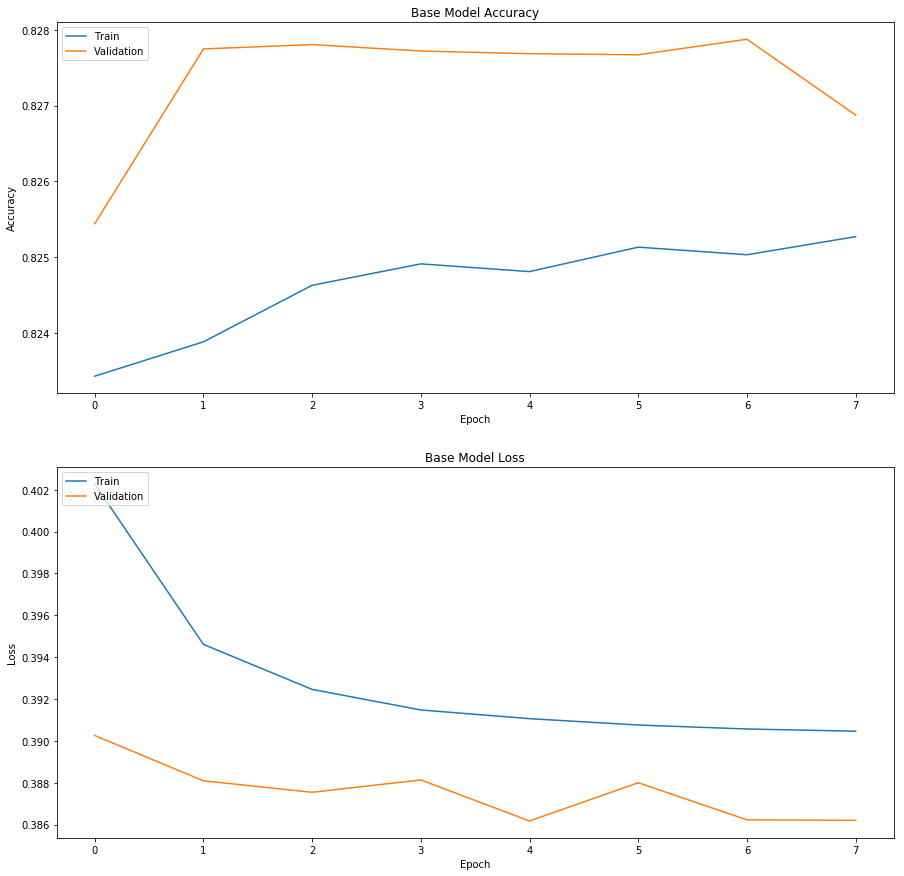

In [14]:
# Plot training history
_ = plt.figure(figsize=(15, 15))

_ = plt.subplot(2, 1, 1)
_ = plt.plot(base_history.history['acc'])
_ = plt.plot(base_history.history['val_acc'])
_ = plt.title('Base Model Accuracy')
_ = plt.ylabel('Accuracy')
_ = plt.xlabel('Epoch')
_ = plt.legend(['Train', 'Validation'], loc='upper left')

_ = plt.subplot(2, 1, 2)
_ = plt.plot(base_history.history['loss'])
_ = plt.plot(base_history.history['val_loss'])
_ = plt.title('Base Model Loss')
_ = plt.ylabel('Loss')
_ = plt.xlabel('Epoch')
_ = plt.legend(['Train', 'Validation'], loc='upper left')

_ = plt.savefig('model_base/model_base_training_perf.png')

In [15]:
# Make predictions on the test set
base_score, base_acc = model_base.evaluate(X_test, y_test)
print('Test score:', base_score)
print('Test accuracy:', base_acc)

532351/532351 [==============================] - 4s 8us/step
Test score: 0.38963236086369024
Test accuracy: 0.8252863242488111


In [16]:
# Make predictions on the test data
base_predictions = model_base.predict_classes(X_test).ravel()

# Print the confusion matrix
confusion_matrix(y_test, base_predictions)

array([[432047,   7870],
       [ 85139,   7295]], dtype=int64)

In [17]:
base_fpr, base_tpr, base_thresholds = roc_curve(y_test, base_predictions)
base_auc= auc(base_fpr, base_tpr)

print(base_auc)

0.5305157189495189


This simple model was able to accurately predict outs roughly 82.53% of the time on the test set. That may seem like a promising result but if the model were to predict only no outs, it would perform the same. It's also worth noting the models true-positive rate is almost nonexistent. That, along with an AUC score of 0.5305, doesn't suggest a huge improvement over random guessing.

### Increase Model Capacity

The next thing to consider is increasing the model capacity to see if it can pick up deeper patterns and improve on several metrics.

In [18]:
# Instatiate a Sequential model
model_deeper = Sequential()

# Create a 3 layers
model_deeper.add(Dense(300, activation = 'relu', input_shape = (X_train.shape[1],)))
model_deeper.add(Dense(100, activation = 'relu'))
model_deeper.add(Dense(100, activation = 'relu'))
model_deeper.add(Dense(1, activation = 'sigmoid'))

# Create a compiler
model_deeper.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [19]:
deeper_checkpoint_path = 'model_deeper/model_deeper.hdf5'
deeper_checkpoint_dir = os.path.dirname(deeper_checkpoint_path)

# Create checkpoint callback
deeper_cp_callback = tf.keras.callbacks.ModelCheckpoint(deeper_checkpoint_path,
                                                        save_best_only = True,
                                                        verbose=1)

In [20]:
# fit the training data to the basic model
deeper_history = model_deeper.fit(X_train,
                                  y_train,
                                  validation_split = 0.25,
                                  epochs = 20,
                                  callbacks = [early_stopping_monitor, deeper_cp_callback])

Train on 1197789 samples, validate on 399263 samples
Epoch 1/20
1197789/1197789 [==============================] - 52s 43us/step - loss: 0.3974 - acc: 0.8258 - val_loss: 0.3892 - val_acc: 0.8276

Epoch 00001: val_loss improved from inf to 0.38924, saving model to model_deeper/model_deeper.hdf5
Epoch 2/20
1197789/1197789 [==============================] - 52s 43us/step - loss: 0.3922 - acc: 0.8257 - val_loss: 0.3862 - val_acc: 0.8276

Epoch 00002: val_loss improved from 0.38924 to 0.38623, saving model to model_deeper/model_deeper.hdf5
Epoch 3/20
1197789/1197789 [==============================] - 53s 44us/step - loss: 0.3909 - acc: 0.8258 - val_loss: 0.3868 - val_acc: 0.8276

Epoch 00003: val_loss did not improve from 0.38623
Epoch 4/20
1197789/1197789 [==============================] - 52s 44us/step - loss: 0.3901 - acc: 0.8258 - val_loss: 0.3864 - val_acc: 0.8279

Epoch 00004: val_loss did not improve from 0.38623
Epoch 5/20
1197789/1197789 [==============================] - 52s 44us/

In [21]:
# Load best model to save training time
model_deeper = keras.models.load_model(deeper_checkpoint_path)

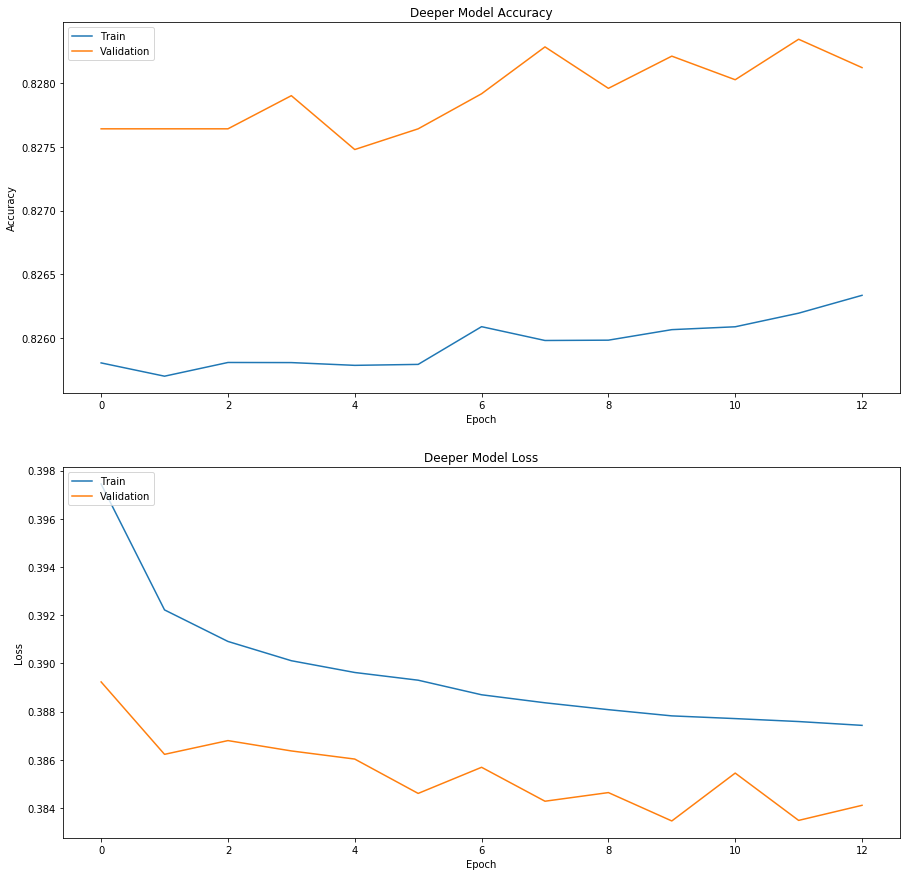

In [22]:
# Plot training history
_ = plt.figure(figsize=(15, 15))

_ = plt.subplot(2, 1, 1)
_ = plt.plot(deeper_history.history['acc'])
_ = plt.plot(deeper_history.history['val_acc'])
_ = plt.title('Deeper Model Accuracy')
_ = plt.ylabel('Accuracy')
_ = plt.xlabel('Epoch')
_ = plt.legend(['Train', 'Validation'], loc='upper left')

_ = plt.subplot(2, 1, 2)
_ = plt.plot(deeper_history.history['loss'])
_ = plt.plot(deeper_history.history['val_loss'])
_ = plt.title('Deeper Model Loss')
_ = plt.ylabel('Loss')
_ = plt.xlabel('Epoch')
_ = plt.legend(['Train', 'Validation'], loc='upper left')

_ = plt.savefig('model_deeper/model_deeper_training_perf.png')

In [23]:
# Make predictions on the test set
deeper_score, deeper_acc = model_deeper.evaluate(X_test, y_test)
print('Test score:', deeper_score)
print('Test accuracy:', deeper_acc)

532351/532351 [==============================] - 8s 15us/step
Test score: 0.387156910145395
Test accuracy: 0.8264115217219068


In [24]:
# Make predictions on the test data
deeper_predictions = model_deeper.predict_classes(X_test)

# Print the confusion matrix
confusion_matrix(y_test, deeper_predictions)

array([[435539,   4378],
       [ 88032,   4402]], dtype=int64)

In [25]:
deeper_fpr, deeper_tpr, deeper_thresholds = roc_curve(y_test, deeper_predictions)
deeper_auc = auc(deeper_fpr, deeper_tpr)

print(deeper_auc)

0.5188356458389293


Increasing the model capacity improved model performance. Not only is it more accurate than the baseline model, but it also has a much better true-positive rate. That can be referenced to an improved AUC score of 0.5188.

This model still needs improvement but next will be to add different predictors and target variables to the model to see how models improve.

## Calls, No Player ID's

In the following model, the other 5 outcomes will be added as target variables for the model to predict. The model should predict the probability of each outcome independent from one another. That's because a pitch can outcome in both a strike and an out.

In [26]:
# Split the data into train and test sets
X_call_train, X_call_test, y_call_train, y_call_test = train_test_split(predictors,
                                                                        calls, 
                                                                        test_size = 0.25, 
                                                                        stratify = calls,
                                                                        random_state = 123)

In [27]:
calls_checkpoint_path = 'model_calls/model_calls.hdf5'
calls_checkpoint_dir = os.path.dirname(calls_checkpoint_path)

# Create checkpoint callback
calls_cp_callback = tf.keras.callbacks.ModelCheckpoint(calls_checkpoint_path,
                                                       save_best_only = True,
                                                       verbose=1)

In [28]:
# Instatiate a Sequential model
model_calls = Sequential()

# Create a basic network
model_calls.add(Dense(300, activation = 'relu', input_shape = (X_call_train.shape[1],)))
model_calls.add(Dense(100, activation = 'relu'))
model_calls.add(Dense(100, activation = 'relu'))
model_calls.add(Dense(y_call_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_calls.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [29]:
# fit the training data to the basic model
calls_history = model_calls.fit(X_call_train,
                                y_call_train,
                                validation_split = 0.25,
                                epochs = 20,
                                callbacks = [early_stopping_monitor, calls_cp_callback])

Train on 1197789 samples, validate on 399263 samples
Epoch 1/20
1197789/1197789 [==============================] - 56s 47us/step - loss: 0.3511 - categorical_accuracy: 0.4937 - val_loss: 0.3464 - val_categorical_accuracy: 0.4959

Epoch 00001: val_loss improved from inf to 0.34636, saving model to model_calls/model_calls.hdf5
Epoch 2/20
1197789/1197789 [==============================] - 56s 47us/step - loss: 0.3452 - categorical_accuracy: 0.4997 - val_loss: 0.3442 - val_categorical_accuracy: 0.5037

Epoch 00002: val_loss improved from 0.34636 to 0.34419, saving model to model_calls/model_calls.hdf5
Epoch 3/20
1197789/1197789 [==============================] - 57s 47us/step - loss: 0.3437 - categorical_accuracy: 0.5025 - val_loss: 0.3436 - val_categorical_accuracy: 0.4982

Epoch 00003: val_loss improved from 0.34419 to 0.34362, saving model to model_calls/model_calls.hdf5
Epoch 4/20
1197789/1197789 [==============================] - 56s 47us/step - loss: 0.3427 - categorical_accuracy: 0.

In [30]:
# Load best model to save training time
model_calls = keras.models.load_model(calls_checkpoint_path)

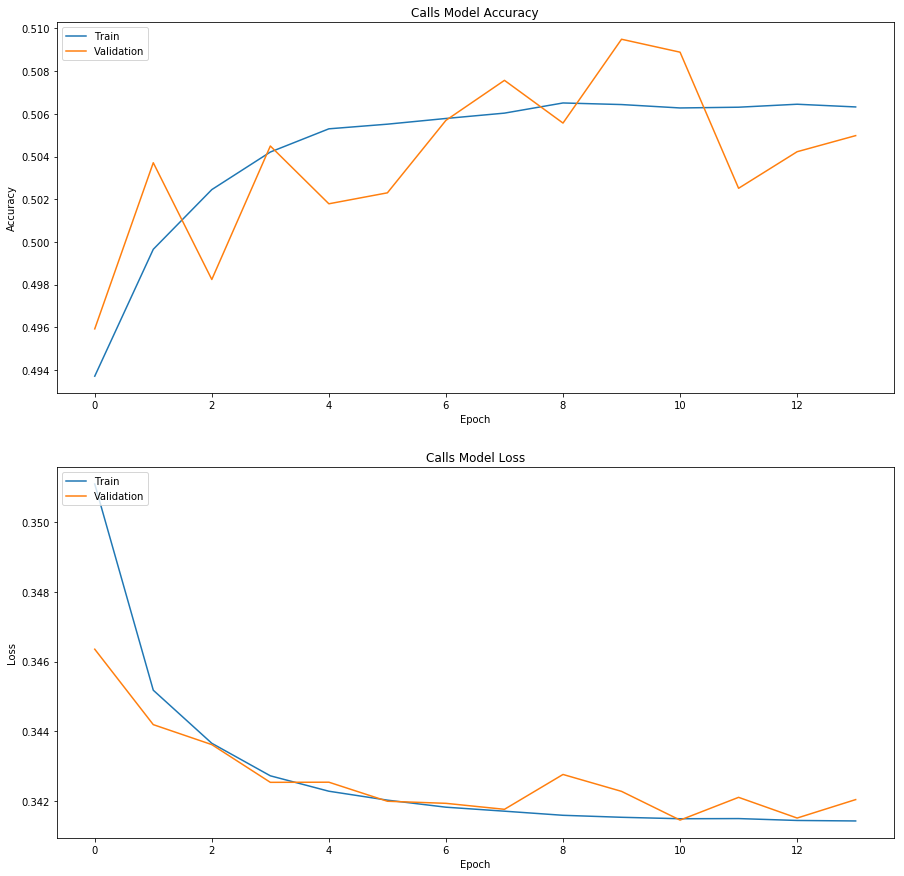

In [31]:
# Plot training history
_ = plt.figure(figsize=(15, 15))

_ = plt.subplot(2, 1, 1)
_ = plt.plot(calls_history.history['categorical_accuracy'])
_ = plt.plot(calls_history.history['val_categorical_accuracy'])
_ = plt.title('Calls Model Accuracy')
_ = plt.ylabel('Accuracy')
_ = plt.xlabel('Epoch')
_ = plt.legend(['Train', 'Validation'], loc='upper left')

_ = plt.subplot(2, 1, 2)
_ = plt.plot(calls_history.history['loss'])
_ = plt.plot(calls_history.history['val_loss'])
_ = plt.title('Calls Model Loss')
_ = plt.ylabel('Loss')
_ = plt.xlabel('Epoch')
_ = plt.legend(['Train', 'Validation'], loc='upper left')

_ = plt.savefig('model_calls/model_calls_training_perf.png')

In [32]:
# Make predictions on the test set
calls_score, calls_acc = model_calls.evaluate(X_call_test, y_call_test)
print('Test score:', calls_score)
print('Test accuracy:', calls_acc)

532351/532351 [==============================] - 8s 15us/step
Test score: 0.3409763822586874
Test accuracy: 0.5104620823470288


In [33]:
# Make predictions on the test data
calls_predictions = model_calls.predict(X_call_test)

# print the confusion matrix
calls_matrix = confusion_matrix(y_call_test.values.argmax(axis=1), calls_predictions.argmax(axis=1))
calls_matrix

array([[158394,  18665,   6313,      0,   1991,   6361],
       [  7850,  62541,  11334,      0,   1935,   5996],
       [ 17857,  21401,  30743,      0,   2485,  20087],
       [  3914,   9446,  10854,      0,   1125,   8816],
       [ 26625,  10450,  12216,      0,   3469,   8226],
       [  9214,  16086,  19065,      0,   2294,  16598]], dtype=int64)

In [34]:
calls_auc = roc_auc_score(y_call_test, calls_predictions)

print(calls_auc)

0.7879845035979834


Looking at the confusion matrix, it appears the model wasn't able to pick up which pitches resulted in hits. More capacity may be needed but this result is promising because of the test accuracy and AUC score. With random guessing, the best you could probably do is predict the most common outcome which in this case is ``call_B`` at around 0.3601. So to build a model that can predict at a 0.5066 rate is encouraging.

## ``is_out``, Player ID's

Integrating player ID numbers could be an easy and useful way of numerically getting player matchup patterns instead of just left-handed/right-handed matchups. That way players who do well against other players or players who have similar play styles could be picked up by the model.

In [35]:
# Extract predictors
predictors_ids = predictors.drop(['pitchHand_isRight', 'batSide_isRight'], axis = 1).join(all_pitches.loc[:,['batter_id', 'pitcher_id']])

In [36]:
# Split the data into train and test sets
X_id_train, X_id_test, y_id_train, y_id_test = train_test_split(predictors_ids,
                                                                targets, 
                                                                test_size = 0.25, 
                                                                stratify = targets,
                                                                random_state = 123)

In [37]:
scaler = StandardScaler()

X_id_train_scaled = scaler.fit_transform(X_id_train)

C:\Users\Curtis\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Curtis\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [38]:
X_id_test_scaled = scaler.transform(X_id_test)

C:\Users\Curtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [39]:
ids_checkpoint_path = 'model_ids/model_ids.hdf5'
ids_checkpoint_dir = os.path.dirname(ids_checkpoint_path)

# Create checkpoint callback
ids_cp_callback = tf.keras.callbacks.ModelCheckpoint(ids_checkpoint_path,
                                                     save_best_only = True,
                                                     verbose=1)

In [40]:
# Instatiate a Sequential model
model_ids = Sequential()

# Create a 3 layers
model_ids.add(Dense(300, activation = 'relu', input_shape = (X_id_train_scaled.shape[1],)))
model_ids.add(Dense(100, activation = 'relu'))
model_ids.add(Dense(1, activation = 'sigmoid'))

# Create a compiler
model_ids.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [41]:
# fit the training data to the basic model
ids_history = model_ids.fit(X_id_train_scaled,
                            y_id_train,
                            validation_split = 0.25,
                            epochs = 20,
                            callbacks = [early_stopping_monitor, ids_cp_callback])

Train on 1197789 samples, validate on 399263 samples
Epoch 1/20
1197789/1197789 [==============================] - 51s 42us/step - loss: 0.3914 - acc: 0.8255 - val_loss: 0.3851 - val_acc: 0.8276

Epoch 00001: val_loss improved from inf to 0.38505, saving model to model_ids/model_ids.hdf5
Epoch 2/20
1197789/1197789 [==============================] - 51s 42us/step - loss: 0.3890 - acc: 0.8257 - val_loss: 0.3850 - val_acc: 0.8280

Epoch 00002: val_loss improved from 0.38505 to 0.38505, saving model to model_ids/model_ids.hdf5
Epoch 3/20
1197789/1197789 [==============================] - 50s 42us/step - loss: 0.3887 - acc: 0.8258 - val_loss: 0.3848 - val_acc: 0.8278

Epoch 00003: val_loss improved from 0.38505 to 0.38480, saving model to model_ids/model_ids.hdf5
Epoch 4/20
1197789/1197789 [==============================] - 50s 42us/step - loss: 0.3886 - acc: 0.8257 - val_loss: 0.3852 - val_acc: 0.8279

Epoch 00004: val_loss did not improve from 0.38480
Epoch 5/20
1197789/1197789 [=========

In [42]:
# Load best model to save training time
model_ids = keras.models.load_model(ids_checkpoint_path)

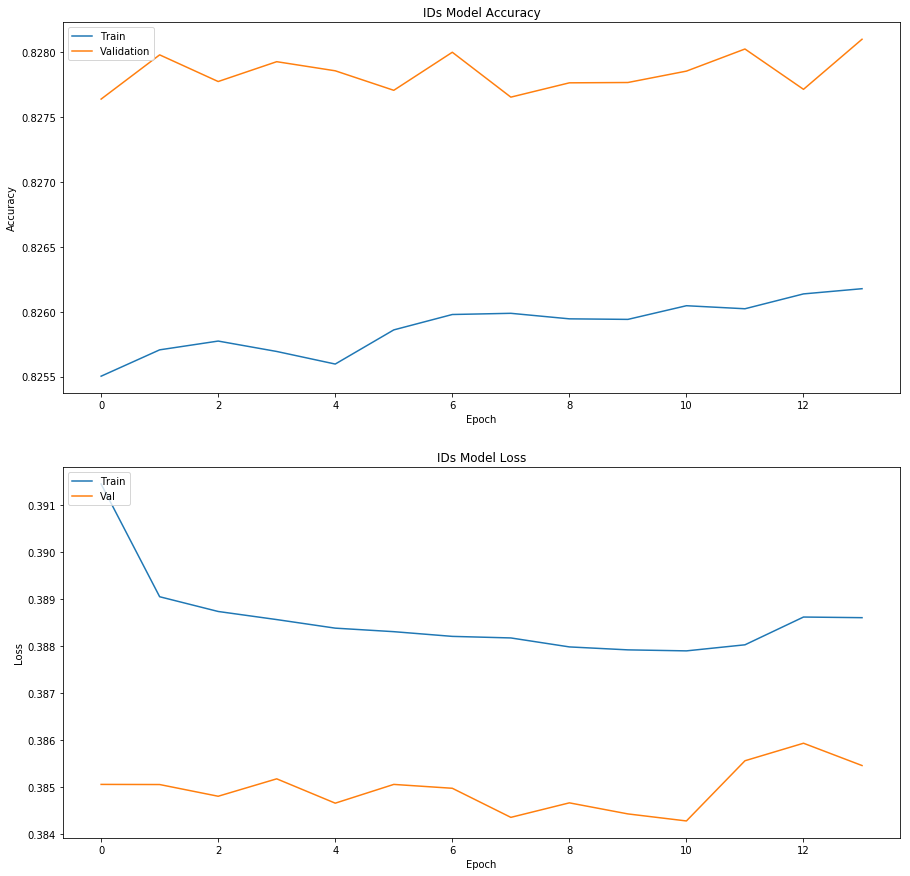

In [43]:
# Plot training history
_ = plt.figure(figsize=(15, 15))

_ = plt.subplot(2, 1, 1)
_ = plt.plot(ids_history.history['acc'])
_ = plt.plot(ids_history.history['val_acc'])
_ = plt.title('IDs Model Accuracy')
_ = plt.ylabel('Accuracy')
_ = plt.xlabel('Epoch')
_ = plt.legend(['Train', 'Validation'], loc='upper left')

_ = plt.subplot(2, 1, 2)
_ = plt.plot(ids_history.history['loss'])
_ = plt.plot(ids_history.history['val_loss'])
_ = plt.title('IDs Model Loss')
_ = plt.ylabel('Loss')
_ = plt.xlabel('Epoch')
_ = plt.legend(['Train', 'Val'], loc='upper left')

_ = plt.savefig('model_ids/model_ids_training_perf.png')

In [44]:
# Make predictions on the test set
ids_score, ids_acc = model_ids.evaluate(X_id_test_scaled, y_id_test)
print('Test score:', ids_score)
print('Test accuracy:', ids_acc)

532351/532351 [==============================] - 7s 14us/step
Test score: 0.3881324946112037
Test accuracy: 0.8262086480521782


In [45]:
# Make predictions on the test data
ids_predictions = model_ids.predict_classes(X_id_test_scaled)

# Print the confusion matrix
confusion_matrix(y_id_test, ids_predictions)

array([[432689,   7228],
       [ 85290,   7144]], dtype=int64)

In [46]:
ids_fpr, ids_tpr, ids_thresholds = roc_curve(y_test, ids_predictions)
ids_auc = auc(ids_fpr, ids_tpr)

print(ids_auc)

0.5304286030354808


Incorporating the player ID numbers into the model compared relatively similar, if not better, than the deeper model above in terms of AUC score. This model also performed comparably similar to the deeper model as well in terms of accuracy.

## Calls, Player ID's

The last model I want to build is a model that introduces player ID numbers to predict the outcome of pitches.

In [47]:
# Split the data into train and test sets
X_callids_train, X_callids_test, y_callids_train, y_callids_test = train_test_split(predictors_ids,
                                                                                    calls, 
                                                                                    test_size = 0.25, 
                                                                                    stratify = calls,
                                                                                    random_state = 123)

In [48]:
scaler_calls = StandardScaler()

X_callids_train_scaled = scaler_calls.fit_transform(X_callids_train)

C:\Users\Curtis\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Curtis\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [49]:
X_callids_test_scaled = scaler_calls.transform(X_callids_test)

C:\Users\Curtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [50]:
callids_checkpoint_path = 'model_callids/model_callids.hdf5'
callids_checkpoint_dir = os.path.dirname(callids_checkpoint_path)

# Create checkpoint callback
callids_cp_callback = tf.keras.callbacks.ModelCheckpoint(callids_checkpoint_path,
                                                         save_best_only = True,
                                                         verbose=1)

In [51]:
# Instatiate a Sequential model
model_calls_id = Sequential()

# Create a basic network
model_calls_id.add(Dense(300, activation = 'relu', input_shape = (X_callids_train_scaled.shape[1],)))
model_calls_id.add(Dense(100, activation = 'relu'))
model_calls_id.add(Dense(100, activation = 'relu'))
model_calls_id.add(Dense(y_callids_train.shape[1], activation = 'sigmoid'))

# Create a compiler
model_calls_id.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [52]:
# fit the training data to the basic model
callids_history = model_calls_id.fit(X_callids_train_scaled,
                                    y_callids_train,
                                    validation_split = 0.25,
                                    epochs = 20,
                                    callbacks = [early_stopping_monitor, callids_cp_callback])

Train on 1197789 samples, validate on 399263 samples
Epoch 1/20
1197789/1197789 [==============================] - 65s 55us/step - loss: 0.3469 - categorical_accuracy: 0.4982 - val_loss: 0.3460 - val_categorical_accuracy: 0.4971

Epoch 00001: val_loss improved from inf to 0.34603, saving model to model_callids/model_callids.hdf5
Epoch 2/20
1197789/1197789 [==============================] - 67s 56us/step - loss: 0.3458 - categorical_accuracy: 0.5005 - val_loss: 0.3455 - val_categorical_accuracy: 0.4984

Epoch 00002: val_loss improved from 0.34603 to 0.34552, saving model to model_callids/model_callids.hdf5
Epoch 3/20
1197789/1197789 [==============================] - 61s 51us/step - loss: 0.3447 - categorical_accuracy: 0.5007 - val_loss: 0.3454 - val_categorical_accuracy: 0.5028

Epoch 00003: val_loss improved from 0.34552 to 0.34538, saving model to model_callids/model_callids.hdf5
Epoch 4/20
1197789/1197789 [==============================] - 64s 54us/step - loss: 0.3445 - categorical_

In [53]:
# Load best model to save training time
model_calls_id = keras.models.load_model(callids_checkpoint_path)

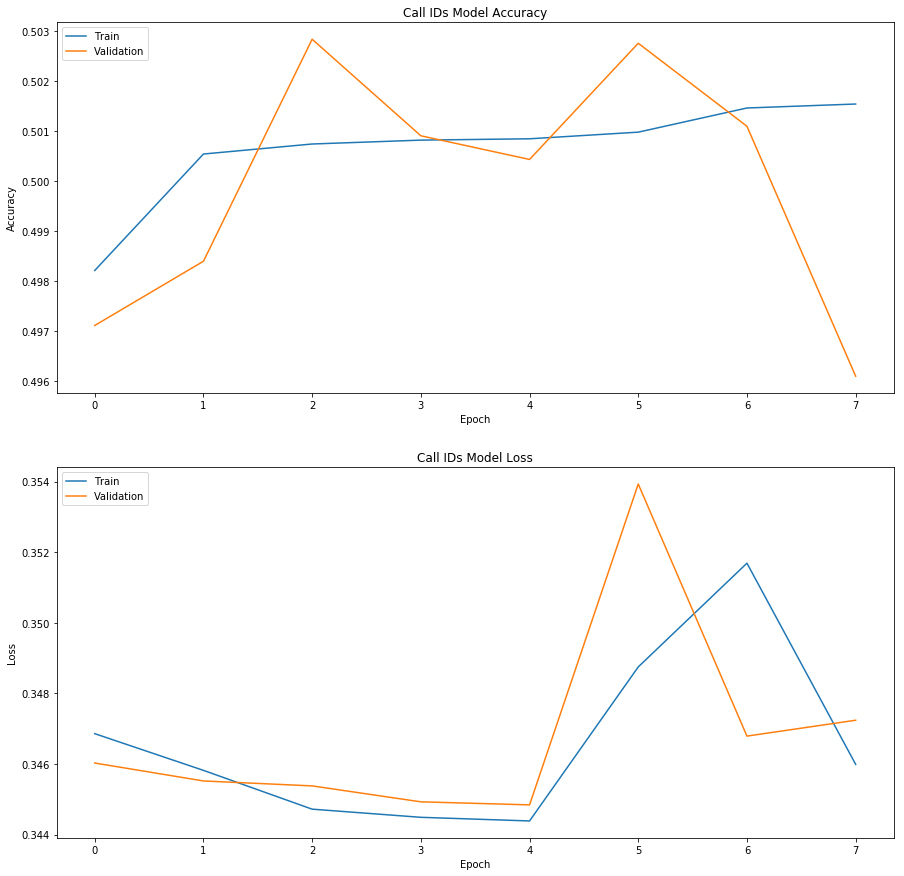

In [54]:
# Plot training history
_ = plt.figure(figsize=(15, 15))

_ = plt.subplot(2, 1, 1)
_ = plt.plot(callids_history.history['categorical_accuracy'])
_ = plt.plot(callids_history.history['val_categorical_accuracy'])
_ = plt.title('Call IDs Model Accuracy')
_ = plt.ylabel('Accuracy')
_ = plt.xlabel('Epoch')
_ = plt.legend(['Train', 'Validation'], loc='upper left')

_ = plt.subplot(2, 1, 2)
_ = plt.plot(callids_history.history['loss'])
_ = plt.plot(callids_history.history['val_loss'])
_ = plt.title('Call IDs Model Loss')
_ = plt.ylabel('Loss')
_ = plt.xlabel('Epoch')
_ = plt.legend(['Train', 'Validation'], loc='upper left')

_ = plt.savefig('model_callids/model_callids_training_perf.png')

In [55]:
# Make predictions on the test set
callids_score, callids_acc = model_calls_id.evaluate(X_callids_test_scaled, y_callids_test)
print('Test score:', callids_score)
print('Test accuracy:', callids_acc)

532351/532351 [==============================] - 10s 18us/step
Test score: 0.34425086059423793
Test accuracy: 0.5012200596967274


In [56]:
# Make predictions on the test data
callids_predictions = model_calls_id.predict(X_callids_test_scaled)

In [57]:
callids_matrix = confusion_matrix(y_callids_test.values.argmax(axis=1), callids_predictions.argmax(axis=1))
callids_matrix

array([[157645,  19311,   6527,      0,   1325,   6916],
       [  7834,  62134,  12560,      0,    888,   6240],
       [ 17760,  22366,  26376,      0,   1571,  24500],
       [  3897,   9714,   9940,      0,    648,   9956],
       [ 26838,  11262,  10923,      0,   2198,   9765],
       [  9291,  16827,  17372,      0,   1295,  18472]], dtype=int64)

In [58]:
callids_auc = roc_auc_score(y_callids_test, callids_predictions)

print(callids_auc)

0.7824589577191832


Just like the previous calls model, when looking at the AUC score, it performed better than models that predicted just outs. Although both models that tried to predict calls had a hard time predicting hits. When moving forward, I think improving on this model would be recommended as this model had better AUC and compared relatively better in accuracy when predicting just outs and it incorpoated player ID numbers which could provide valuable insight into certain matchups.